### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.utils import shuffle
from lightgbm import LGBMRegressor
from joblib import Parallel, delayed
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
!gdown --id 13NfLMq7bgqNGeiaCCKRk--njjksIaRTy
!unzip -q '/content/Crop_data.zip'

Downloading...
From: https://drive.google.com/uc?id=13NfLMq7bgqNGeiaCCKRk--njjksIaRTy
To: /content/Crop_data.zip
858MB [00:07, 109MB/s] 


In [3]:
!unzip -q '/content/Crop_data/image_arrays_test.zip'
!unzip -q '/content/Crop_data/image_arrays_train.zip'

### Loading data

In [4]:
train = pd.read_csv('/content/Crop_data/Train.csv')
sample = pd.read_csv('/content/Crop_data/SampleSubmission.csv')
test = sample.copy()
info = pd.read_csv('/content/Crop_data/fields_w_additional_info.csv')
train.head()

,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


In [5]:
# Selecting only soil data
info_cols = info.filter(like = '5-15cm').columns.tolist() + ['Field_ID']
info = info[info_cols]
info.head()

,soil_bdod_5-15cm_mean,soil_cec_5-15cm_mean,soil_cfvo_5-15cm_mean,soil_clay_5-15cm_mean,soil_nitrogen_5-15cm_mean,soil_ocd_5-15cm_mean,soil_phh2o_5-15cm_mean,soil_sand_5-15cm_mean,soil_silt_5-15cm_mean,soil_soc_5-15cm_mean,Field_ID
0,118.0,257.0,85.0,463.0,2458.0,323.0,59.0,308.0,229.0,330.0,MH2O0YH
1,120.0,288.0,84.0,462.0,2108.0,306.0,61.0,243.0,295.0,280.0,O9TURWL
2,120.0,263.0,102.0,495.0,1991.0,288.0,60.0,271.0,234.0,284.0,35AFSDD
3,122.0,206.0,66.0,431.0,2432.0,337.0,57.0,332.0,237.0,335.0,PM05EG9
4,124.0,167.0,116.0,439.0,566.0,302.0,56.0,326.0,235.0,187.0,V7PZBCG


In [6]:
# Previewing band names
band_names = [l.strip() for l in open('/content/Crop_data/bandnames.txt', 'r').readlines()]
print(band_names)

['0_S2_B1', '0_S2_B2', '0_S2_B3', '0_S2_B4', '0_S2_B5', '0_S2_B6', '0_S2_B7', '0_S2_B8', '0_S2_B8A', '0_S2_B9', '0_S2_B10', '0_S2_B11', '0_S2_B12', '0_S2_QA10', '0_S2_QA20', '0_S2_QA60', '0_CLIM_aet', '0_CLIM_def', '0_CLIM_pdsi', '0_CLIM_pet', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '0_CLIM_srad', '0_CLIM_swe', '0_CLIM_tmmn', '0_CLIM_tmmx', '0_CLIM_vap', '0_CLIM_vpd', '0_CLIM_vs', '1_S2_B1', '1_S2_B2', '1_S2_B3', '1_S2_B4', '1_S2_B5', '1_S2_B6', '1_S2_B7', '1_S2_B8', '1_S2_B8A', '1_S2_B9', '1_S2_B10', '1_S2_B11', '1_S2_B12', '1_S2_QA10', '1_S2_QA20', '1_S2_QA60', '1_CLIM_aet', '1_CLIM_def', '1_CLIM_pdsi', '1_CLIM_pet', '1_CLIM_pr', '1_CLIM_ro', '1_CLIM_soil', '1_CLIM_srad', '1_CLIM_swe', '1_CLIM_tmmn', '1_CLIM_tmmx', '1_CLIM_vap', '1_CLIM_vpd', '1_CLIM_vs', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B9', '2_S2_B10', '2_S2_B11', '2_S2_B12', '2_S2_QA10', '2_S2_QA20', '2_S2_QA60', '2_CLIM_aet', '2_CLIM_def', '2_CLIM_pdsi', '2

In [7]:
# Checking the shape of train, test and info files
train.shape, test.shape, info.shape

((2977, 4), (1055, 2), (4032, 11))

In [8]:
# Creating lists of different qualities
quality_1, quality_2, quality_3, = train[train.Quality == 1].index, train[train.Quality == 2].index, train[train.Quality == 2].index

In [9]:
# Checking value counts of each Quality
train.Quality.value_counts()

3    1321
2    1231
1     425
Name: Quality, dtype: int64

In [10]:
# Checking the number of fields per year
train.Year.value_counts()

2017    1203
2016    1024
2019     569
2018     181
Name: Year, dtype: int64

In [11]:
# Adding data path to the images
train['path'] = ['/content/image_arrays_train/' + x + '.npy' for x in train.Field_ID]
test['path'] = ['/content/image_arrays_test/' + x + '.npy' for x in test.Field_ID]
target, year, quality = train.Yield, train.Year, train.Quality
test.head()

,Field_ID,Yield,path
0,E9UZCEA,0,/content/image_arrays_test/E9UZCEA.npy
1,1WGGS1Q,0,/content/image_arrays_test/1WGGS1Q.npy
2,EG2KXE2,0,/content/image_arrays_test/EG2KXE2.npy
3,HC3GQXF,0,/content/image_arrays_test/HC3GQXF.npy
4,7AK6GFK,0,/content/image_arrays_test/7AK6GFK.npy


In [12]:
# Combining training and test data for easy manipulation
train_df, test_df = train.copy(), test.copy()
splitter = train_df.shape[0]
comb = pd.concat([train_df, test_df], join = 'inner')
comb_field = comb.Field_ID
comb.head()

,Field_ID,Yield,path
0,MH2O0YH,3.686,/content/image_arrays_train/MH2O0YH.npy
1,O9TURWL,5.657,/content/image_arrays_train/O9TURWL.npy
2,35AFSDD,3.082,/content/image_arrays_train/35AFSDD.npy
3,PM05EG9,2.707,/content/image_arrays_train/PM05EG9.npy
4,V7PZBCG,2.679,/content/image_arrays_train/V7PZBCG.npy


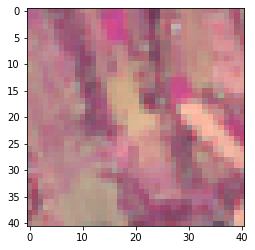

In [13]:
# Previewing a single image
xx = np.load(train.path.loc[0])
rgb = np.stack([xx[4], xx[3], xx[2]], axis = -1); rgb = rgb/np.max(rgb)
plt.imshow(rgb)
plt.show()

In [14]:
# %%time
# Selecting relevant bands
main_bands = ['S2_B5', 'S2_B4', 'S2_B3', 'S2_B2', 'CLIM_pr', 'CLIM_soil', 'S2_B8', 'S2_B11']

def process_im(path, bands=main_bands):
  arr = np.load(path)
  values = {}
  for month in range(12):
    bns = [str(month) + '_' + b for b in bands] # Bands of interest for this month 
    idxs = np.where(np.isin(band_names, bns)) # Index of these bands
    vs = arr[idxs, 20, 20] # Sample the im at the center point
    for bn, v in zip(bns, vs[0]):
      values[bn] = v
  return values

# Multiprocessing to speed up sampling the center of each image for each band
results = Parallel(n_jobs=-1, verbose=3, backend="multiprocessing")(map(delayed(process_im), [x for x in comb.path.values]))
comb = pd.DataFrame(results)
comb.head()

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2992 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4032 out of 4032 | elapsed:    1.4s finished


,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,0_S2_B8,0_S2_B11,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,1_CLIM_pr,1_CLIM_soil,1_S2_B8,1_S2_B11,2_S2_B5,2_S2_B4,2_S2_B3,2_S2_B2,2_CLIM_pr,2_CLIM_soil,2_S2_B8,2_S2_B11,3_S2_B5,3_S2_B4,3_S2_B3,3_S2_B2,3_CLIM_pr,3_CLIM_soil,3_S2_B8,3_S2_B11,4_S2_B5,4_S2_B4,4_S2_B3,4_S2_B2,4_CLIM_pr,4_CLIM_soil,4_S2_B8,4_S2_B11,...,7_S2_B5,7_S2_B4,7_S2_B3,7_S2_B2,7_CLIM_pr,7_CLIM_soil,7_S2_B8,7_S2_B11,8_S2_B5,8_S2_B4,8_S2_B3,8_S2_B2,8_CLIM_pr,8_CLIM_soil,8_S2_B8,8_S2_B11,9_S2_B5,9_S2_B4,9_S2_B3,9_S2_B2,9_CLIM_pr,9_CLIM_soil,9_S2_B8,9_S2_B11,10_S2_B5,10_S2_B4,10_S2_B3,10_S2_B2,10_CLIM_pr,10_CLIM_soil,10_S2_B8,10_S2_B11,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil,11_S2_B8,11_S2_B11
0,934,932,1173,1392,2038,2907,4,287,1015,1036,1397,1516,2095,3091,7,236,1034,1075,1518,1640,2084,3207,14,200,1048,1085,1455,1561,1951,2930,47,175,1024,1084,1449,1605,2031,3002,76,155,...,1743,1487,1272,1743,2740,2198,92,116,903,928,1155,1322,1862,2454,81,107,893,998,903,1307,2642,2317,96,99,841,894,690,1162,2373,1782,83,93,744,699,393,790,1845,985,125,215
1,880,821,924,1116,1951,2404,4,287,933,873,1011,1152,1695,2468,7,237,905,881,1020,1167,1758,2581,15,203,1893,1888,2178,2344,2906,3668,50,178,906,882,916,1037,1983,2353,80,158,...,850,848,679,939,2453,1690,92,119,891,873,943,1135,1908,2419,74,110,841,844,817,1098,2126,2315,79,102,806,862,512,1037,3818,1832,78,96,703,524,323,420,891,469,126,215
2,1016,1070,1357,1632,2137,3567,4,278,1108,1193,1588,1947,2381,3815,7,230,978,1018,1346,1472,1780,3112,15,197,1086,1117,1426,1584,1971,3280,50,173,1045,1095,1460,1663,2097,3455,77,154,...,838,798,552,859,2790,1622,89,116,845,908,764,1215,2670,1975,69,107,833,896,796,1186,2463,2090,73,100,967,1091,929,1538,3163,2603,75,93,2935,2961,3598,4145,4173,4898,135,289
3,777,784,639,1064,2588,2123,3,299,832,875,823,1237,2582,2431,8,244,878,903,916,1231,2406,2575,14,207,932,907,973,1254,2242,2627,48,180,858,858,844,1108,2210,2409,79,159,...,3057,2836,2781,2997,3226,2132,94,119,764,779,501,982,3262,1796,85,109,798,823,581,1039,3036,1897,106,102,776,784,537,947,2716,1681,86,95,7289,7389,8025,8057,8648,7406,121,189
4,1081,1122,1162,1487,2603,2986,20,427,1046,1063,1133,1454,2230,2643,18,300,1222,1339,1542,1834,2949,3376,35,234,985,1072,1046,1462,2890,2783,179,384,826,826,507,851,3621,1660,159,568,...,980,995,882,1130,2699,1995,75,218,889,959,698,1178,3229,1993,85,182,923,984,694,1223,3179,2249,237,1179,973,958,657,1050,2696,1620,122,1123,1054,1097,789,1349,3455,2428,194,1214


In [15]:
# Scaling data using square root
comb = comb**(1/2.0)

### Feature Engineering - Vegetation Indices

In [16]:
# Calculation of vegetation indices
def vegetation_index(i):
    b2 = comb.filter(like = "B2").values[:,i]
    b3 = comb.filter(like = "B3").values[:,i]
    b4 = comb.filter(like = "B4").values[:,i]
    b5 = comb.filter(like = "B5").values[:,i]
    b8 = comb.filter(like = "B8").values[:,i]   

    ndvi = (b8 - b4) / (b8 + b4) #NDVI
    gndvi = (b8 - b3) / (b8 + b3) # GNDVI
    wdrvi = (0.1 * b5 - b4)/ (0.1 * b5 + b4) #WDRVI
    ndre = (b5 - b4)/ (b5 + b4) # NDRE
    return [wdrvi, gndvi, ndvi, ndre]
    
# Multiprocessing to speed up vegetation indices calculation
spectral_indices = ['WDRVI', "GNDVI", 'NDVI', 'NDRE']
vegs = Parallel(n_jobs=-1, verbose=2, backend="multiprocessing")(map(delayed(vegetation_index), [x for x in range(12)]))

# Adding the calculated indices to the combined dataframe
for i in tqdm_notebook(range(12)):
  for x, y in zip(spectral_indices, vegs[i]):
    comb[x+'_'+str(i)] = y

# Selecting relevant indices only
relevant_indices = comb.filter(like = 'WDRVI').columns.tolist() + comb.filter(like = 'GNVDI').columns.tolist() + comb.filter(like = 'NDVI').columns.tolist()+\
                   comb.filter(like = 'NDRE').columns.tolist() 
comb = comb[relevant_indices]

# Previewing the head of the engineered dataframe
comb.head()

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished


,WDRVI_0,WDRVI_1,WDRVI_2,WDRVI_3,WDRVI_4,WDRVI_5,WDRVI_6,WDRVI_7,WDRVI_8,WDRVI_9,WDRVI_10,WDRVI_11,GNDVI_0,NDVI_0,GNDVI_1,NDVI_1,GNDVI_2,NDVI_2,GNDVI_3,NDVI_3,GNDVI_4,NDVI_4,GNDVI_5,NDVI_5,GNDVI_6,NDVI_6,GNDVI_7,NDVI_7,GNDVI_8,NDVI_8,GNDVI_9,NDVI_9,GNDVI_10,NDVI_10,GNDVI_11,NDVI_11,NDRE_0,NDRE_1,NDRE_2,NDRE_3,NDRE_4,NDRE_5,NDRE_6,NDRE_7,NDRE_8,NDRE_9,NDRE_10,NDRE_11
0,-0.818005,-0.819867,-0.821370,-0.821029,-0.822833,-0.815815,-0.800636,-0.804620,-0.820426,-0.827163,-0.823170,-0.812959,-0.889652,-0.877032,-0.867786,-0.848088,-0.824760,-0.795140,-0.695305,-0.655451,-0.627313,-0.581297,-0.790561,-0.785978,-0.381966,-0.488895,-0.576123,-0.601620,-0.581252,-0.543878,-0.508232,-0.526544,-0.484970,-0.532921,-0.278794,-0.405601,0.000536,-0.005120,-0.009721,-0.008674,-0.014234,0.007119,0.050867,0.039691,-0.006827,-0.027785,-0.015277,0.015596
1,-0.812364,-0.812613,-0.815948,-0.817963,-0.815951,-0.804456,-0.818182,-0.817987,-0.816488,-0.818476,-0.823657,-0.792392,-0.876533,-0.869507,-0.846365,-0.835628,-0.783695,-0.769154,-0.736842,-0.720081,-0.543773,-0.537079,-0.416167,-0.506865,-0.521925,-0.575336,-0.461888,-0.504462,-0.562341,-0.549013,-0.525601,-0.531459,-0.438526,-0.537502,-0.231092,-0.341953,0.017348,0.016616,0.006719,0.000661,0.006712,0.040156,0.000000,0.000589,0.005102,-0.000890,-0.016791,0.073334
2,-0.822417,-0.824199,-0.821468,-0.820495,-0.822008,-0.816163,-0.816086,-0.814099,-0.824038,-0.824118,-0.827910,-0.818909,-0.897007,-0.884762,-0.875481,-0.857700,-0.809029,-0.783506,-0.684563,-0.650748,-0.626477,-0.580805,-0.823642,-0.819306,-0.466443,-0.561032,-0.427005,-0.499296,-0.537843,-0.567810,-0.535115,-0.555893,-0.557470,-0.584546,-0.675459,-0.648092,-0.012946,-0.018477,-0.010021,-0.007036,-0.011684,0.006076,0.006307,0.012227,-0.017975,-0.018225,-0.030154,-0.002205
3,-0.818922,-0.822304,-0.820489,-0.815922,-0.818182,-0.811691,-0.810603,-0.811884,-0.819782,-0.820715,-0.819028,-0.819305,-0.871750,-0.883489,-0.820511,-0.825453,-0.779949,-0.778545,-0.636517,-0.625954,-0.531459,-0.534404,-0.431271,-0.508109,-0.591015,-0.618284,-0.689403,-0.691964,-0.416532,-0.503393,-0.401409,-0.471797,-0.428381,-0.502403,-0.781274,-0.773101,-0.002242,-0.012597,-0.007019,0.006797,0.000000,0.019325,0.022505,0.018758,-0.004861,-0.007712,-0.002564,-0.003406
4,-0.821235,-0.819510,-0.825598,-0.825057,-0.818182,-0.812738,-0.818182,-0.819433,-0.824349,-0.823402,-0.816894,-0.821460,-0.768044,-0.764429,-0.776130,-0.769712,-0.738136,-0.721651,-0.414751,-0.419820,-0.282044,-0.390104,-0.479770,-0.557782,-0.649886,-0.697331,-0.548460,-0.569183,-0.482618,-0.541171,-0.262324,-0.341590,-0.397702,-0.473992,-0.337020,-0.407925,-0.009306,-0.004030,-0.022855,-0.021157,0.000000,0.016248,0.000000,-0.003798,-0.018946,-0.015998,0.003884,-0.009996


In [17]:
# Merging the combined dataframe with soil data, based on field id
comb['Field_ID'] = comb_field.reset_index(drop = True)
comb = comb.merge(info, how = 'left', left_on=['Field_ID'], right_on=['Field_ID'])
comb = comb.drop('Field_ID', axis = 1)

# Dropping overfitting feature
comb = comb.drop(['NDVI_5'], axis = 1)

In [18]:
# Separating the training data set from the test dataset
train_df = comb[:splitter]
test_df = comb[splitter:]

# Adding back the target variable to the training set
train_df['Yield'] = target

# Previewing the engineered training set
train_df.head()

,WDRVI_0,WDRVI_1,WDRVI_2,WDRVI_3,WDRVI_4,WDRVI_5,WDRVI_6,WDRVI_7,WDRVI_8,WDRVI_9,WDRVI_10,WDRVI_11,GNDVI_0,NDVI_0,GNDVI_1,NDVI_1,GNDVI_2,NDVI_2,GNDVI_3,NDVI_3,GNDVI_4,NDVI_4,GNDVI_5,GNDVI_6,NDVI_6,GNDVI_7,NDVI_7,GNDVI_8,NDVI_8,GNDVI_9,NDVI_9,GNDVI_10,NDVI_10,GNDVI_11,NDVI_11,NDRE_0,NDRE_1,NDRE_2,NDRE_3,NDRE_4,NDRE_5,NDRE_6,NDRE_7,NDRE_8,NDRE_9,NDRE_10,NDRE_11,soil_bdod_5-15cm_mean,soil_cec_5-15cm_mean,soil_cfvo_5-15cm_mean,soil_clay_5-15cm_mean,soil_nitrogen_5-15cm_mean,soil_ocd_5-15cm_mean,soil_phh2o_5-15cm_mean,soil_sand_5-15cm_mean,soil_silt_5-15cm_mean,soil_soc_5-15cm_mean,Yield
0,-0.818005,-0.819867,-0.821370,-0.821029,-0.822833,-0.815815,-0.800636,-0.804620,-0.820426,-0.827163,-0.823170,-0.812959,-0.889652,-0.877032,-0.867786,-0.848088,-0.824760,-0.795140,-0.695305,-0.655451,-0.627313,-0.581297,-0.790561,-0.381966,-0.488895,-0.576123,-0.601620,-0.581252,-0.543878,-0.508232,-0.526544,-0.484970,-0.532921,-0.278794,-0.405601,0.000536,-0.005120,-0.009721,-0.008674,-0.014234,0.007119,0.050867,0.039691,-0.006827,-0.027785,-0.015277,0.015596,118.0,257.0,85.0,463.0,2458.0,323.0,59.0,308.0,229.0,330.0,3.686
1,-0.812364,-0.812613,-0.815948,-0.817963,-0.815951,-0.804456,-0.818182,-0.817987,-0.816488,-0.818476,-0.823657,-0.792392,-0.876533,-0.869507,-0.846365,-0.835628,-0.783695,-0.769154,-0.736842,-0.720081,-0.543773,-0.537079,-0.416167,-0.521925,-0.575336,-0.461888,-0.504462,-0.562341,-0.549013,-0.525601,-0.531459,-0.438526,-0.537502,-0.231092,-0.341953,0.017348,0.016616,0.006719,0.000661,0.006712,0.040156,0.000000,0.000589,0.005102,-0.000890,-0.016791,0.073334,120.0,288.0,84.0,462.0,2108.0,306.0,61.0,243.0,295.0,280.0,5.657
2,-0.822417,-0.824199,-0.821468,-0.820495,-0.822008,-0.816163,-0.816086,-0.814099,-0.824038,-0.824118,-0.827910,-0.818909,-0.897007,-0.884762,-0.875481,-0.857700,-0.809029,-0.783506,-0.684563,-0.650748,-0.626477,-0.580805,-0.823642,-0.466443,-0.561032,-0.427005,-0.499296,-0.537843,-0.567810,-0.535115,-0.555893,-0.557470,-0.584546,-0.675459,-0.648092,-0.012946,-0.018477,-0.010021,-0.007036,-0.011684,0.006076,0.006307,0.012227,-0.017975,-0.018225,-0.030154,-0.002205,120.0,263.0,102.0,495.0,1991.0,288.0,60.0,271.0,234.0,284.0,3.082
3,-0.818922,-0.822304,-0.820489,-0.815922,-0.818182,-0.811691,-0.810603,-0.811884,-0.819782,-0.820715,-0.819028,-0.819305,-0.871750,-0.883489,-0.820511,-0.825453,-0.779949,-0.778545,-0.636517,-0.625954,-0.531459,-0.534404,-0.431271,-0.591015,-0.618284,-0.689403,-0.691964,-0.416532,-0.503393,-0.401409,-0.471797,-0.428381,-0.502403,-0.781274,-0.773101,-0.002242,-0.012597,-0.007019,0.006797,0.000000,0.019325,0.022505,0.018758,-0.004861,-0.007712,-0.002564,-0.003406,122.0,206.0,66.0,431.0,2432.0,337.0,57.0,332.0,237.0,335.0,2.707
4,-0.821235,-0.819510,-0.825598,-0.825057,-0.818182,-0.812738,-0.818182,-0.819433,-0.824349,-0.823402,-0.816894,-0.821460,-0.768044,-0.764429,-0.776130,-0.769712,-0.738136,-0.721651,-0.414751,-0.419820,-0.282044,-0.390104,-0.479770,-0.649886,-0.697331,-0.548460,-0.569183,-0.482618,-0.541171,-0.262324,-0.341590,-0.397702,-0.473992,-0.337020,-0.407925,-0.009306,-0.004030,-0.022855,-0.021157,0.000000,0.016248,0.000000,-0.003798,-0.018946,-0.015998,0.003884,-0.009996,124.0,167.0,116.0,439.0,566.0,302.0,56.0,326.0,235.0,187.0,2.679


In [19]:
# Checking the shape of training and testing dataset
train_df.shape, test_df.shape

((2977, 58), (1055, 57))

In [20]:
%%time
# Separating good quality fields from bad quality fields
good_quality = train_df[~train_df.index.isin(quality_1)].reset_index(drop = True) # Quality 2 and 3
bad_quality = train_df[train_df.index.isin(quality_1)].reset_index(drop = True) # Only quality 1

# A copy of the test data
tess = test_df.copy()

# Selecting good quality data to be used in validation and all data to be used in training
X, y  = good_quality[good_quality.columns[:-1]], good_quality['Yield']
XX, yy = bad_quality[bad_quality.columns[:-1]], bad_quality['Yield']

# Selecting the number of folds
folds = KFold(n_splits = 5)

# Dataframe to store feature importance for each fold
feature_importance_df = pd.DataFrame()

# Lists to store predictions and rmse per fold
predictions = []
rmses = []
for i,( train_index, test_index) in enumerate(folds.split(X, y)):
  # Good quality data split - X_test, y_test to be used for validation only
  X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]

  # Concatenating good and bad quality data to be used in training
  X_train, y_train = pd.concat([X_train, XX]), pd.concat([y_train, yy])
  X_train, y_train = shuffle(X_train, y_train, random_state = 55)
  
  # Instantiating the LGBM model
  model = LGBMRegressor(n_estimators=4000, eval_metric = 'rmse', learning_rate=0.1, reg_alpha=2)

  # Instantiating the TransformedTargetRegressor wrapper model
  wrapped_model = TransformedTargetRegressor(regressor=model, transformer=StandardScaler())

  # Training the model
  wrapped_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose = False)

  # Making predictions
  # Model over predicted by a constant of 0.2, so subtract 0.2
  preds = wrapped_model.predict(tess)-0.2
  y_pred = wrapped_model.predict(X_test)-0.2

  # Appending predictions for each fold
  predictions.append(preds)

  # Calculating the rmse for each fold
  rmse = mean_squared_error(y_test, y_pred)**0.5

  # Feature importance per fold
  fold_importance_df = pd.DataFrame({'feature': X_train.columns.tolist(), 'importance': wrapped_model.regressor_.feature_importances_})
  feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

  # Printing rmse for each fold
  print(i, rmse)
  rmses.append(rmse)

print(f'Mean RMSE: {np.mean(rmses)}')
# Averaging predictions
mpreds = np.mean(predictions, 0)

# Submission file creation
ss = sample.copy()
ss['Yield'] = mpreds
ss.to_csv('CGIAR_LGBM.csv', index=False)

0 1.788416002591417
1 1.8532952296207232
2 1.4645300833323345
3 1.5751780891661524
4 1.6498938697918173
Mean RMSE: 1.666262654900489
CPU times: user 2min 9s, sys: 318 ms, total: 2min 10s
Wall time: 3.38 s


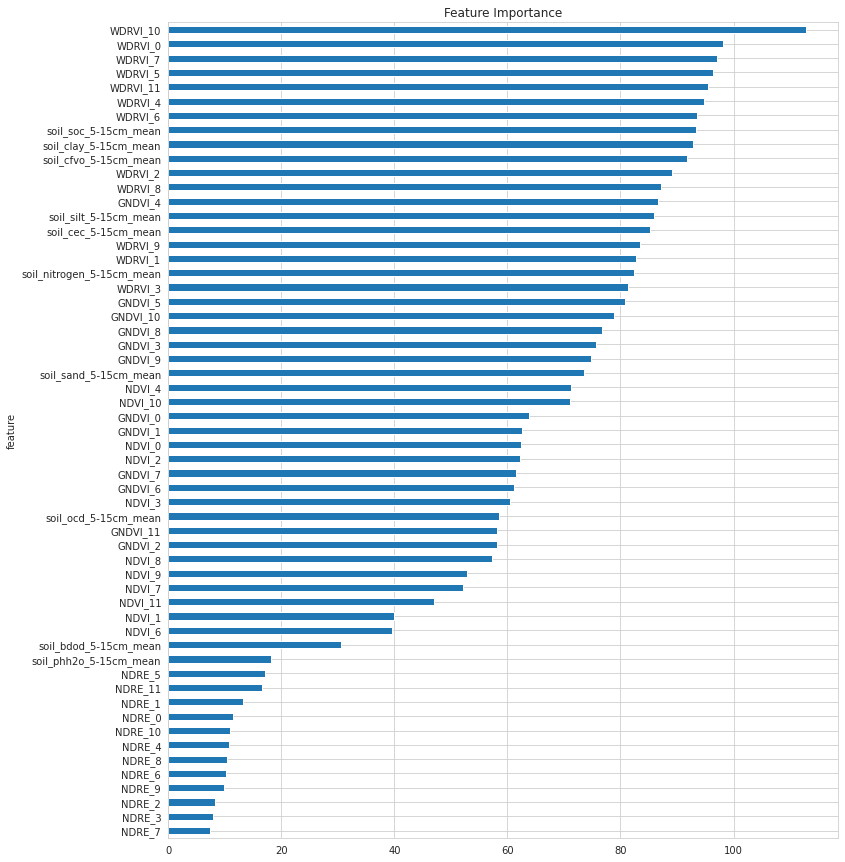

In [21]:
# Feature Importance plot
sns.set_style('whitegrid')
fi = feature_importance_df.groupby('feature')['importance'].mean()
fi.sort_values(ascending=False)[::-1].plot(kind = 'barh', figsize=(12, 15), title = 'Feature Importance')
plt.show()